In [3]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [4]:
!wget http://www.manythings.org/anki/ind-eng.zip
!unzip ind-eng.zip

--2020-12-21 08:17:35--  http://www.manythings.org/anki/ind-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 172.67.173.198, 104.24.108.196, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279153 (273K) [application/zip]
Saving to: ‘ind-eng.zip’

ind-eng.zip         100%[===================>] 272.61K  --.-KB/s    in 0.1s    

2020-12-21 08:17:35 (2.05 MB/s) - ‘ind-eng.zip’ saved [279153/279153]

Archive:  ind-eng.zip
  inflating: _about.txt              
  inflating: ind.txt                 


In [5]:
path_to_file = "./ind.txt"

In [6]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ",w)
  w = re.sub(r"[^a-zA-Z?.!,¿]+"," ", w)
  w = w.strip()

  #adding a start and an end token to the sentence, so the model know when to start and when to end
  w = '<start> ' + w + ' <end>'
  return w

In [7]:
en_sentence = u"May I borrow your book?"
ind_sentence = u"¿Bolehkah Saya pinjam buku anda?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(ind_sentence).encode('utf-8'))

<start> may i borrow your book ? <end>
b'<start> \xc2\xbf bolehkah saya pinjam buku anda ? <end>'


In [8]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  words_pairs = []

  for l in lines[:num_examples]:
    word_pairs = []
    for w in l.split('\t'):
      if w[:5] == 'CC-BY':
        break
      word_pairs.append(preprocess_sentence(w))
    words_pairs.append(word_pairs)

  return zip(*words_pairs)

In [9]:
en, ind = create_dataset('./ind.txt', None)

In [10]:
print(en[-1])
print(ind[-1])

<start> if a person has not had a chance to acquire his target language by the time he s an adult , he s unlikely to be able to reach native speaker level in that language . <end>
<start> jika seseorang tidak berkesempatan untuk menguasai bahasa yang diinginkannya ketika menginjak dewasa , maka kecil kemungkinan ia akan bisa mencapai tingkatan penutur asli dalam bahasa tersebut . <end>


In [11]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [12]:
def load_dataset(path, num_examples=None):
  targ_lang, inp_lang = create_dataset(path, num_examples)

  target_tensor, target_tokenizer = tokenize(targ_lang)
  input_tensor, input_tokenizer = tokenize(inp_lang)

  return input_tensor, target_tensor, input_tokenizer, target_tokenizer

In [13]:
input_tensor, target_tensor, input_tokenizer, target_tokenizer = load_dataset('./ind.txt')

In [47]:
max_length_targ, max_lenght_inp = target_tensor.shape[1], input_tensor.shape[1]

In [15]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

5717 5717 1430 1430


In [16]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print("%d -----> %s"%(t, lang.index_word[t]))

In [17]:
print ("Input Language; index to word mapping")
convert(input_tokenizer, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(target_tokenizer, target_tensor_train[0])

Input Language; index to word mapping
1 -----> <start>
13 -----> itu
138 -----> cukup
3 -----> .
2 -----> <end>

Target Language; index to word mapping
1 -----> <start>
17 -----> that
13 -----> s
208 -----> enough
3 -----> .
2 -----> <end>


In [20]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
inp_lang = input_tokenizer
targ_lang = target_tokenizer
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [21]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 29]), TensorShape([64, 38]))

In [22]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

  def call(self,x,hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output,state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.enc_units))

In [23]:
#sample of encoder
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [24]:
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [25]:
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 29, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [26]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query,1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(values)+self.W2(query_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weight = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weight * values
    context_vector = tf.reduce_sum(context_vector,axis=1)

    return context_vector, attention_weight

In [27]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 29, 1)


In [28]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences = True, return_state = True, recurrent_initializer='glorot_uniform')
    
    self.fc = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weight = self.attention(hidden, enc_output)

    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)

    output, state = self.gru(x)

    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.fc(output)

    return x, state, attention_weight

In [29]:
#sample Decoder
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 3583)


In [30]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real,pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [32]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    #teacher forcing method
    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:,t], predictions)

      dec_input = tf.expand_dims(targ[:,t],1)
    
    batch_loss = (loss/int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [33]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.7599
Epoch 1 Loss 1.1485
Time taken for 1 epoch 62.12774419784546 sec

Epoch 2 Batch 0 Loss 0.9209
Epoch 2 Loss 0.9414
Time taken for 1 epoch 25.415677547454834 sec

Epoch 3 Batch 0 Loss 0.8390
Epoch 3 Loss 0.8272
Time taken for 1 epoch 25.270966291427612 sec

Epoch 4 Batch 0 Loss 0.7682
Epoch 4 Loss 0.7512
Time taken for 1 epoch 25.93952751159668 sec

Epoch 5 Batch 0 Loss 0.6970
Epoch 5 Loss 0.6848
Time taken for 1 epoch 25.8406925201416 sec

Epoch 6 Batch 0 Loss 0.5720
Epoch 6 Loss 0.6218
Time taken for 1 epoch 26.614359617233276 sec

Epoch 7 Batch 0 Loss 0.5448
Epoch 7 Loss 0.5604
Time taken for 1 epoch 26.098541021347046 sec

Epoch 8 Batch 0 Loss 0.4676
Epoch 8 Loss 0.4997
Time taken for 1 epoch 26.501379013061523 sec

Epoch 9 Batch 0 Loss 0.4377
Epoch 9 Loss 0.4381
Time taken for 1 epoch 26.153932332992554 sec

Epoch 10 Batch 0 Loss 0.3390
Epoch 10 Loss 0.3800
Time taken for 1 epoch 26.602840423583984 sec



In [59]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_lenght_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_lenght_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [60]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [37]:
!zip -r checkpoint_NMT.zip ./training_checkpoints

  adding: training_checkpoints/ (stored 0%)
  adding: training_checkpoints/ckpt-3.index (deflated 70%)
  adding: training_checkpoints/ckpt-4.data-00000-of-00001 (deflated 18%)
  adding: training_checkpoints/ckpt-2.data-00000-of-00001 (deflated 18%)
  adding: training_checkpoints/checkpoint (deflated 38%)
  adding: training_checkpoints/ckpt-4.index (deflated 70%)
  adding: training_checkpoints/ckpt-1.data-00000-of-00001 (deflated 18%)
  adding: training_checkpoints/ckpt-1.index (deflated 70%)
  adding: training_checkpoints/ckpt-3.data-00000-of-00001 (deflated 18%)
  adding: training_checkpoints/ckpt-5.index (deflated 70%)
  adding: training_checkpoints/ckpt-2.index (deflated 70%)
  adding: training_checkpoints/ckpt-5.data-00000-of-00001 (deflated 18%)


In [61]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [62]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> siapa kamu ? <end>
Predicted translation: what s your name ? <end> 


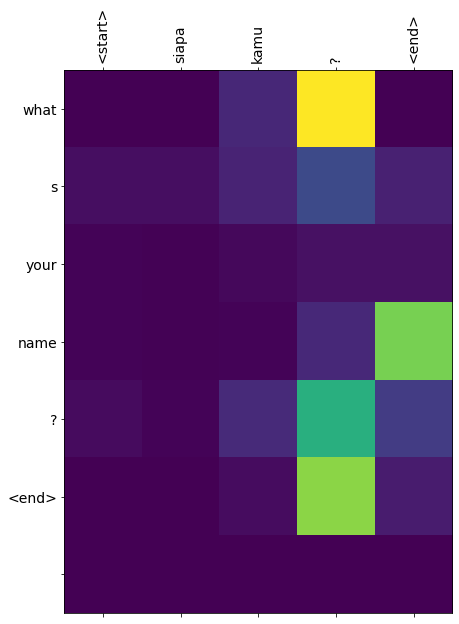

In [69]:
translate(u'siapa kamu?')

In [58]:
max_lenght_inp

29